In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [94]:
def plot_images(*images, titles=None, cmap='gray'):
    """
    Plots an arbitrary number of images in a subplot.

    Parameters:
    *images: list of numpy.ndarray
        The images to be plotted.
    titles: list of str, optional
        Titles for each subplot. If None, no titles will be displayed.
    cmap: str, optional
        Colormap to be used for displaying the images. Default is 'gray'.
    """
    num_images = len(images)
    plt.figure(figsize=(10, 5 * num_images))

    for i, image in enumerate(images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap=cmap)
        if titles and i < len(titles):
            plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [167]:
def plot_threshold(channel, thresh_channel):
    # Plot the original, each thresholded channel, and histograms
    plt.figure(figsize=(15, 8))

    # Green Channel Thresholded
    plt.subplot(3, 3, 1)
    plt.title('Input Channel')
    plt.imshow(channel, cmap='gray')

    # Red Channel Thresholded
    plt.subplot(3, 3, 2)
    plt.title('Thresholded Channel')
    plt.imshow(thresh_channel, cmap='gray')

    # Red Channel Histogram
    plt.subplot(3, 3, 3)
    plt.title('Channel Histogram')
    plt.hist(channel.ravel(), bins=256, color='black', alpha=0.7)
    plt.xlim([0, 256])

# test 1

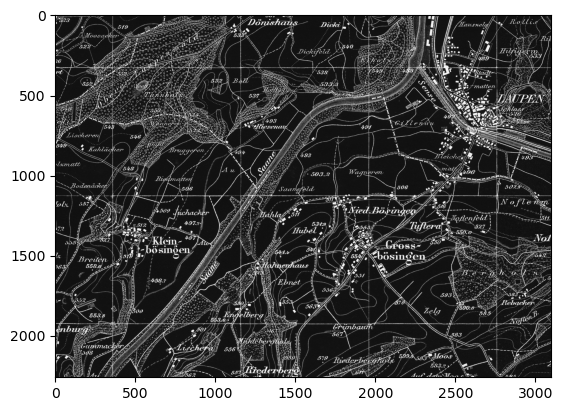

In [90]:
# Load the historical map image
image = cv2.imread('data/Siegfried.tif', cv2.IMREAD_GRAYSCALE)
image_neg = cv2.bitwise_not(image)

plt.imshow(image_neg, cmap='gray')

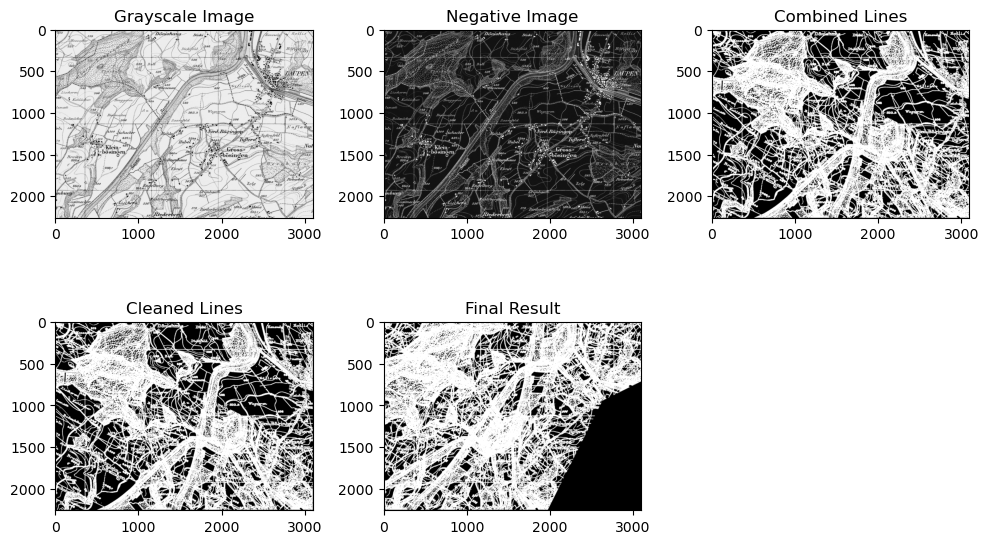

In [57]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Function to convert image to grayscale
def to_grayscale(image):
    # Convert BGR to grayscale using the provided formula
    grayscale_image = 0.233 * image[:,:,2] + 0.587 * image[:,:,1] + 0.114 * image[:,:,0]
    return grayscale_image.astype(np.uint8)

# Function to generate a negative image
def negative_image(image):
    return 255 - image

# Function to apply the shear transform
def shear_transform(image, direction='horizontal', shear_factor=1):
    rows, cols = image.shape
    if direction == 'horizontal':
        M = np.float32([[1, shear_factor, 0], [0, 1, 0]])  # Horizontal shear matrix
    else:
        M = np.float32([[1, 0, 0], [shear_factor, 1, 0]])  # Vertical shear matrix
    return cv2.warpAffine(image, M, (cols, rows))

# Function to calculate energy density in an area
def calculate_energy_density(image, window_size):
    kernel = np.ones((window_size, window_size), np.float32) / (window_size ** 2)
    energy_density = cv2.filter2D(image.astype(np.float32) ** 2, -1, kernel)
    return energy_density

# Function to apply template matching and thresholding based on energy density
def apply_template_matching(energy_density, template_size, threshold):
    rows, cols = energy_density.shape
    lines_image = np.zeros((rows, cols), np.uint8)

    # Define a thresholding rule based on energy density differences
    for i in range(template_size, rows - template_size):
        for j in range(template_size, cols - template_size):
            local_patch = energy_density[i - template_size:i + template_size, j - template_size:j + template_size]
            if np.max(local_patch) - np.mean(local_patch) > threshold:
                lines_image[i, j] = 255
    return lines_image

# Function to remove isolated regions (small noise)
def remove_small_regions(image, min_area_size=10):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(image, connectivity=8)
    cleaned_image = np.zeros(image.shape, dtype=np.uint8)
    
    # Keep only regions that are larger than the threshold
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area_size:
            cleaned_image[labels == i] = 255
    return cleaned_image

# Function to reverse the shear transform
def inverse_shear_transform(image, direction='horizontal', shear_factor=1):
    return shear_transform(image, direction, -shear_factor)

# Main processing function
def linear_feature_separation(image_path):
    # Step 1: Load image
    image = cv2.imread(image_path)
    
    # Step 2: Convert color image to grayscale
    gray_image = to_grayscale(image)
    
    # Step 3: Generate negative image
    negative_img = negative_image(gray_image)
    
    # Step 4: Apply shear transform
    shear_horizontal = shear_transform(negative_img, direction='horizontal', shear_factor=0.5)
    shear_vertical = shear_transform(negative_img, direction='vertical', shear_factor=0.5)
    
    # Step 5: Calculate energy density in local regions
    energy_density_horizontal = calculate_energy_density(shear_horizontal, window_size=3)
    energy_density_vertical = calculate_energy_density(shear_vertical, window_size=3)
    
    # Step 6: Apply template matching for line detection
    template_size = 2
    threshold = 4000  # Example threshold value
    lines_horizontal = apply_template_matching(energy_density_horizontal, template_size, threshold)
    lines_vertical = apply_template_matching(energy_density_vertical, template_size, threshold)
    
    # Step 7: Union operation to combine results
    combined_lines = cv2.bitwise_or(lines_horizontal, lines_vertical)
    
    # Step 8: Remove small regions (noise)
    cleaned_lines = remove_small_regions(combined_lines, min_area_size=10)
    
    # Step 9: Inverse shear transform
    final_horizontal = inverse_shear_transform(cleaned_lines, direction='horizontal', shear_factor=0.5)
    final_vertical = inverse_shear_transform(cleaned_lines, direction='vertical', shear_factor=0.5)
    
    # Combine final result
    final_result = cv2.bitwise_or(final_horizontal, final_vertical)
    
    # Display the results
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 3, 1), plt.imshow(gray_image, cmap='gray'), plt.title('Grayscale Image')
    plt.subplot(2, 3, 2), plt.imshow(negative_img, cmap='gray'), plt.title('Negative Image')
    plt.subplot(2, 3, 3), plt.imshow(combined_lines, cmap='gray'), plt.title('Combined Lines')
    plt.subplot(2, 3, 4), plt.imshow(cleaned_lines, cmap='gray'), plt.title('Cleaned Lines')
    plt.subplot(2, 3, 5), plt.imshow(final_result, cmap='gray'), plt.title('Final Result')
    plt.tight_layout()
    plt.show()

# Run the process
linear_feature_separation('data/Siegfried.tif')


In [45]:
# Function to apply the shear transform
def shear_transform(image, direction='horizontal', shear_factor=1):
    rows, cols = image.shape
    if direction == 'horizontal':
        M = np.float32([[1, shear_factor, 0], [0, 1, 0]])  # Horizontal shear matrix
    else:
        M = np.float32([[1, 0, 0], [shear_factor, 1, 0]])  # Vertical shear matrix
    return cv2.warpAffine(image, M, (cols, rows))


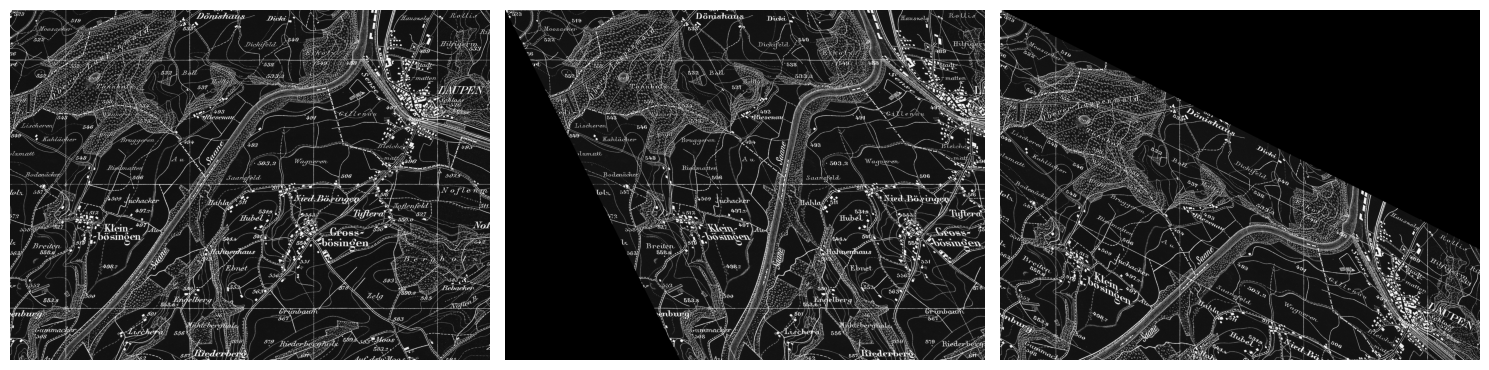

In [53]:
image_sheared_hrz = shear_transform(image_neg, direction='horizontal', shear_factor=0.5)
image_sheared_vert = shear_transform(image_neg, direction='vertical', shear_factor=0.5)

plot_images(image_neg, image_sheared_hrz, image_sheared_vert)

In [54]:
# Function to calculate energy density in an area
def calculate_energy_density(image, window_size):
    kernel = np.ones((window_size, window_size), np.float32) / (window_size ** 2)
    energy_density = cv2.filter2D(image.astype(np.float32) ** 2, -1, kernel)
    return energy_density

# Function to apply template matching and thresholding based on energy density
def apply_template_matching(energy_density, template_size, threshold):
    rows, cols = energy_density.shape
    lines_image = np.zeros((rows, cols), np.uint8)

    # Define a thresholding rule based on energy density differences
    for i in range(template_size, rows - template_size):
        for j in range(template_size, cols - template_size):
            local_patch = energy_density[i - template_size:i + template_size, j - template_size:j + template_size]
            if np.max(local_patch) - np.mean(local_patch) > threshold:
                lines_image[i, j] = 255
    return lines_image


In [55]:
calculate_energy_density(image_neg, 3)

array([[40606.11   , 42555.445  , 60611.336  , ...,   716.44446,
          762.3334 ,  1032.     ],
       [43921.668  , 45646.11   , 61389.555  , ...,   653.4444 ,
          731.3333 ,   982.44434],
       [53696.777  , 53921.668  , 64133.668  , ...,   488.55554,
          495.3333 ,   468.66666],
       ...,
       [  329.55554,   323.44446,   316.33334, ...,   307.22223,
          336.22223,   386.22223],
       [  333.     ,   315.44446,   316.1111 , ...,   254.44444,
          236.66666,   253.77777],
       [  387.55554,   333.00003,   314.6667 , ...,   223.     ,
          221.     ,   207.00002]], dtype=float32)

# Test 2

In [173]:
# Load the historical map image
image = cv2.imread('data/Siegfried.tif', cv2.IMREAD_COLOR)

# Convert the image to grayscale
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Convert the image from BGR (OpenCV default) to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Split the image into R, G, B channels
R, G, B = cv2.split(image_rgb)

In [174]:
def threshold_diff(img,threshold_low, threshold_high):
    _, thresh_low = cv2.threshold(img, threshold_low, 255, cv2.THRESH_BINARY)
    _, thresh_high = cv2.threshold(img, threshold_high, 255, cv2.THRESH_BINARY)
    return cv2.bitwise_xor(thresh_low, thresh_high)

In [175]:
def segmentation(image):
    # Convert the image to grayscale
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Convert the image from BGR (OpenCV default) to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Split the image into R, G, B channels
    R, G, B = cv2.split(image_rgb)
    
    # Define threshold values for each channel
    threshold_R = 100  # Adjust for Red channel
    threshold_G = 0  # Adjust for Green channel
    threshold_B = 100  # Adjust for Blue channel
    threshold_Gray = 50 # Adjust for Gray channel

    # Step 1: Threshold each channel separately
    _, thresh_R = cv2.threshold(R, threshold_R, 255, cv2.THRESH_BINARY)
    _, thresh_G = cv2.threshold(G, threshold_G, 255, cv2.THRESH_BINARY)
    _, thresh_B = cv2.threshold(B, threshold_B, 255, cv2.THRESH_BINARY)
    _, thresh_Gray = cv2.threshold(image_gray, threshold_Gray, 255, cv2.THRESH_BINARY)
    
    R_diff = threshold_diff(R, 100, 200)
    G_diff = threshold_diff(G, 25, 200)
    B_diff = threshold_diff(B, 100, 200)
    Gray_diff = threshold_diff(image_gray, 70, 200)
    
    
    kernel_2 = np.ones((2,2),np.uint8)
    kernel_5 = np.ones((5,5),np.uint8)

    R_erosion = cv2.erode(R_diff,kernel_2,iterations = 1)
    R_opening = cv2.morphologyEx(R_diff, cv2.MORPH_OPEN, kernel_2)

    thresh_G_inv = 255-thresh_G
    G_dilation = cv2.dilate(thresh_G_inv,kernel_2,iterations = 2)
    G_errosion = cv2.erode(G_dilation,kernel_2,iterations = 1)
    #G_opening = cv2.morphologyEx(thresh_G_inv, cv2.MORPH_OPEN, kernel_5)

    Gray_errosion = cv2.erode(Gray_diff,kernel_2,iterations = 1)
    Gray_dilation = cv2.dilate(Gray_errosion,kernel_2,iterations = 1)
    
    # Assuming binary_image1 and binary_image2 are your two binary images
    combined_image = cv2.bitwise_or(R_opening, Gray_dilation)

    combined_dilation = cv2.dilate(combined_image, kernel_5, iterations=1)
    combined_errosion = cv2.erode(combined_dilation, kernel_5, iterations=1)


    result_image = cv2.subtract(combined_errosion, G_errosion)
    result_erosion = cv2.erode(result_image, kernel_2, iterations=1)
    result_dilation = cv2.dilate(result_erosion, kernel_2, iterations=1)
    
    return result_dilation
    


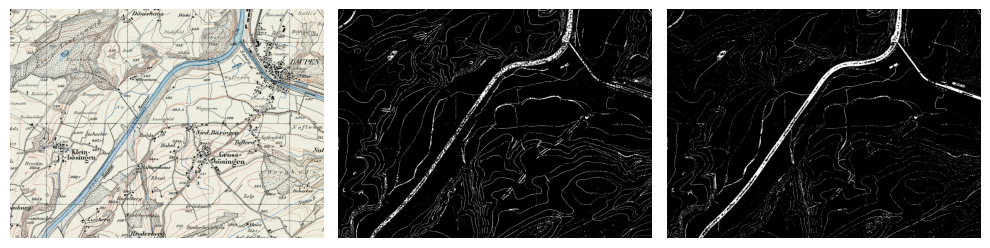

In [240]:
result = segmentation(image)
plot_images(image_rgb, result, segmentation(image_rgb))

### Manual segmentation 1

The following steps are all included into the function *segmentation()*

In [148]:
def crop_img(img, x, y, w, h):
    return img[y:y+h, x:x+w]

In [149]:

# Step 4: Define the position and size of the crop
x_start = 50  # x-coordinate of the top-left corner
y_start = 300  # y-coordinate of the top-left corner
width = 100    # Width of the crop
height = 100   # Height of the crop

# Step 5: Crop the image using array slicing
cropped_image = crop_img(image_rgb, x_start, y_start, width, height)
cropped_image_gray = crop_img(image_gray, x_start, y_start, width, height)

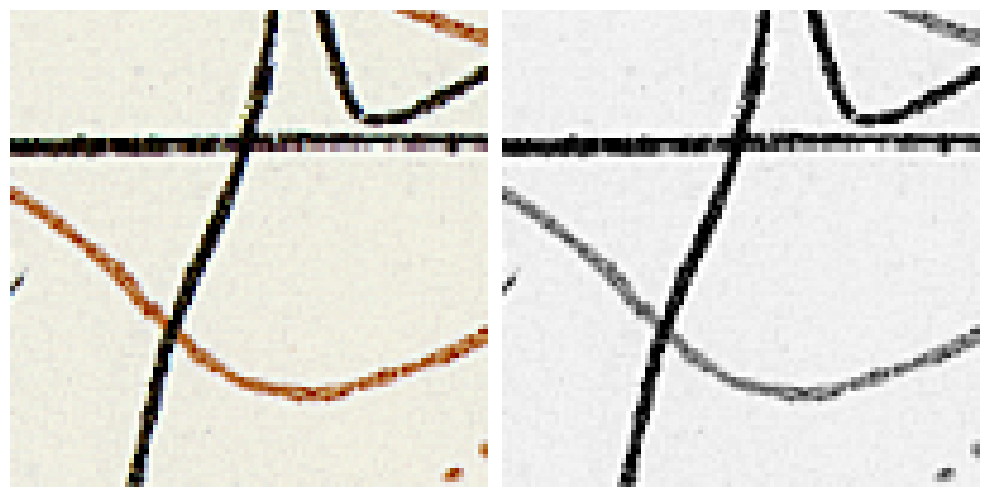

In [150]:
plot_images(cropped_image, cropped_image_gray)

In [104]:
# Split the image into R, G, B channels
R, G, B = cv2.split(cropped_image)

# Define threshold values for each channel
threshold_R = 100  # Adjust for Red channel
threshold_G = 0  # Adjust for Green channel
threshold_B = 100  # Adjust for Blue channel
threshold_Gray = 50 # Adjust for Gray channel

# Step 1: Threshold each channel separately
_, thresh_R = cv2.threshold(R, threshold_R, 255, cv2.THRESH_BINARY)
_, thresh_G = cv2.threshold(G, threshold_G, 255, cv2.THRESH_BINARY)
_, thresh_B = cv2.threshold(B, threshold_B, 255, cv2.THRESH_BINARY)
_, thresh_Gray = cv2.threshold(cropped_image_gray, threshold_Gray, 255, cv2.THRESH_BINARY)

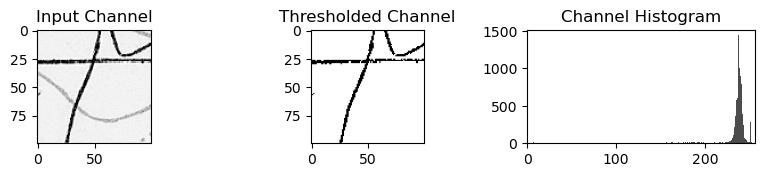

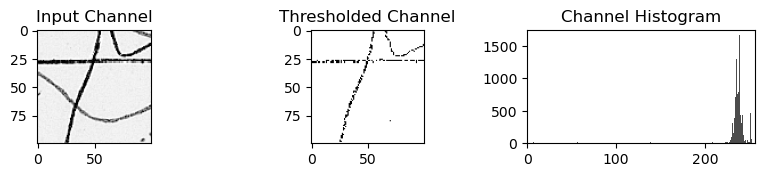

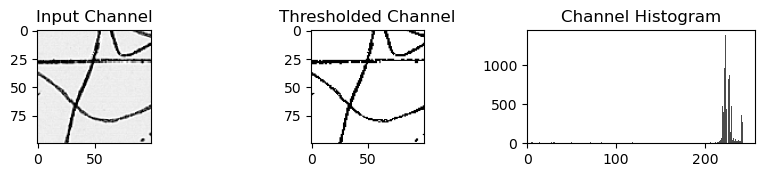

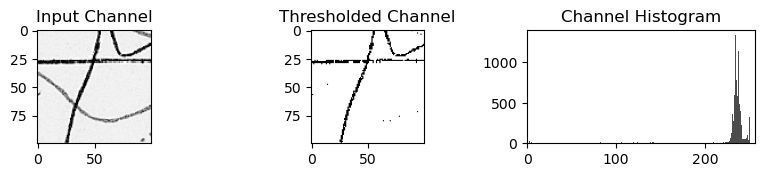

In [105]:
plot_threshold(R,thresh_R)
plot_threshold(G,thresh_G)
plot_threshold(B,thresh_B)
plot_threshold(cropped_image_gray,thresh_Gray)

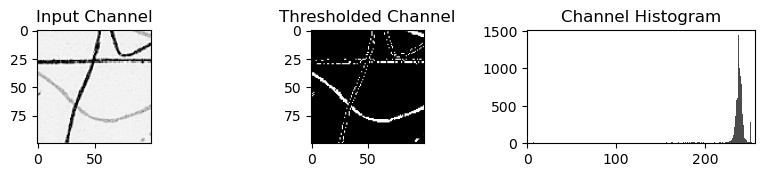

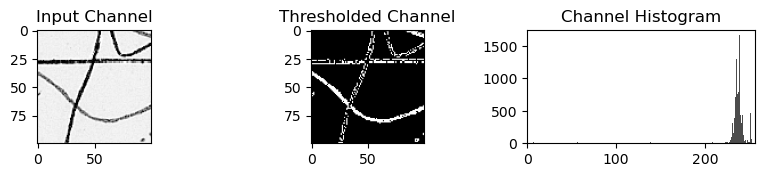

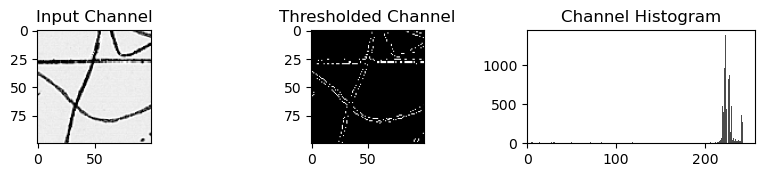

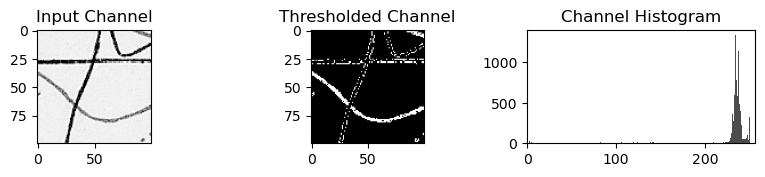

In [115]:
R_diff = threshold_diff(R, 100, 200)
G_diff = threshold_diff(G, 25, 200)
B_diff = threshold_diff(B, 100, 200)
Gray_diff = threshold_diff(cropped_image_gray, 70, 200)

plot_threshold(R, R_diff)
plot_threshold(G, G_diff)
plot_threshold(B, B_diff)
plot_threshold(cropped_image_gray, Gray_diff)

#### Interpretation

- R channel: best detection when threshold difference
- R channel: only threshold
- B channel: not usable 

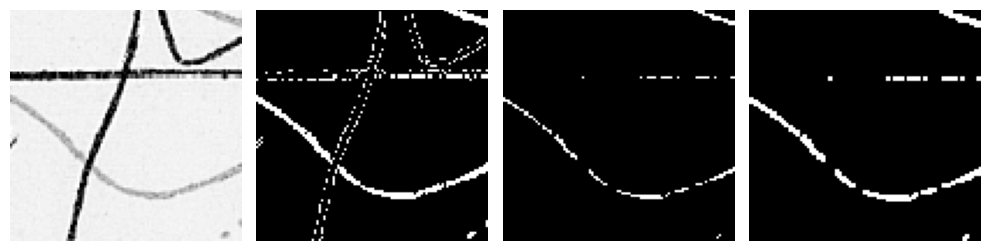

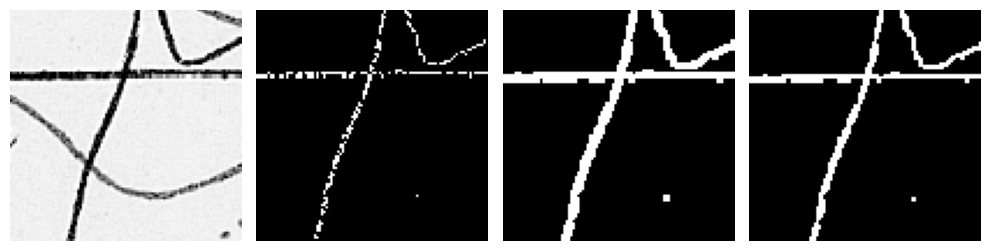

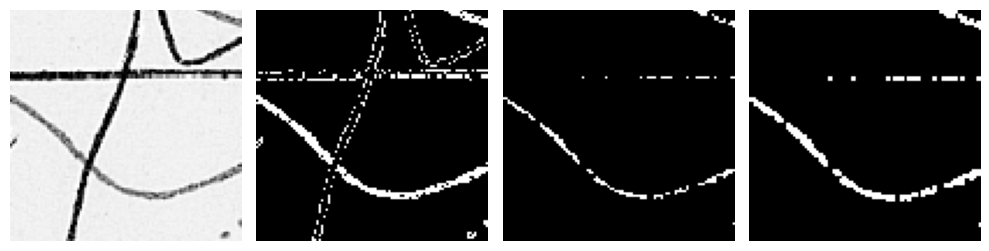

In [120]:
kernel_2 = np.ones((2,2),np.uint8)
kernel_5 = np.ones((5,5),np.uint8)

R_erosion = cv2.erode(R_diff,kernel_2,iterations = 1)
R_opening = cv2.morphologyEx(R_diff, cv2.MORPH_OPEN, kernel_2)

thresh_G_inv = 255-thresh_G
G_dilation = cv2.dilate(thresh_G_inv,kernel_2,iterations = 2)
G_errosion = cv2.erode(G_dilation,kernel_2,iterations = 1)
#G_opening = cv2.morphologyEx(thresh_G_inv, cv2.MORPH_OPEN, kernel_5)

Gray_errosion = cv2.erode(Gray_diff,kernel_2,iterations = 1)
Gray_dilation = cv2.dilate(Gray_errosion,kernel_2,iterations = 1)

plot_images(R,R_diff, R_erosion, R_opening)
plot_images(G,thresh_G_inv, G_dilation,G_errosion)
plot_images(cropped_image_gray,Gray_diff, Gray_errosion, Gray_dilation)

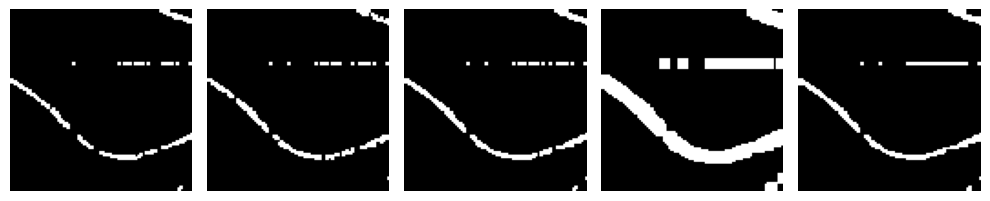

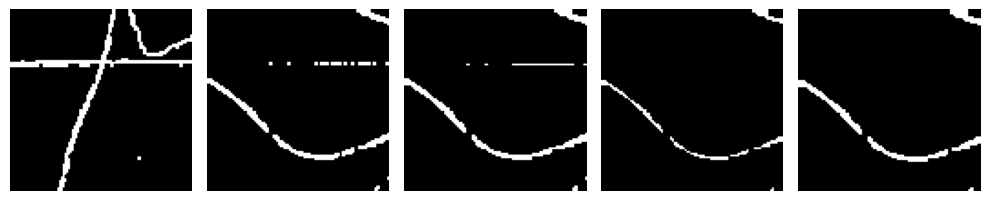

In [140]:
# Assuming binary_image1 and binary_image2 are your two binary images
combined_image = cv2.bitwise_or(R_opening, Gray_dilation)

combined_dilation = cv2.dilate(combined_image, kernel_5, iterations=1)
combined_errosion = cv2.erode(combined_dilation, kernel_5, iterations=1)


result_image = cv2.subtract(combined_errosion, G_errosion)
result_erosion = cv2.erode(result_image, kernel_2, iterations=1)
result_dilation = cv2.dilate(result_erosion, kernel_2, iterations=1)


plot_images(R_opening, Gray_dilation, combined_image, combined_dilation, combined_errosion)
plot_images(G_errosion, combined_image, result_image, result_erosion, result_dilation)

## Manuel Segmentation 2

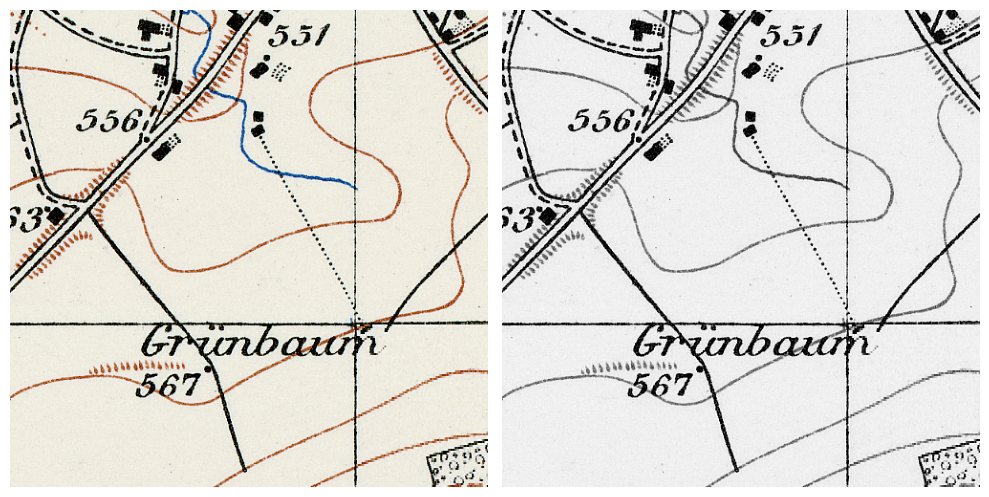

In [222]:
# Step 4: Define the position and size of the crop
x_start = 1600  # x-coordinate of the top-left corner
y_start = 1600  # y-coordinate of the top-left corner
width = 500    # Width of the crop
height =500   # Height of the crop

# Step 5: Crop the image using array slicing
cropped_image_2 = crop_img(image_rgb, x_start, y_start, width, height)
cropped_image_gray_2 = crop_img(image_gray, x_start, y_start, width, height)

plot_images(cropped_image_2, cropped_image_gray_2)

In [223]:
def segmentation_2(image):
    
    # Split the image into R, G, B channels
    B2, G2, R2 = cv2.split(image)

    # Define threshold values for each channel
    threshold_B_2 = 25  # Adjust for Blue channel

    _, thresh_B = cv2.threshold(B2, threshold_B_2, 255, cv2.THRESH_BINARY)
    
    kernel_2 = np.ones((3,3),np.uint8)
    
    
    diff = cv2.subtract(B2, thresh_B)

    B2_thresh_erosion = cv2.erode(thresh_B, kernel_2, iterations=1)

    
    return 255-B2_thresh_erosion

    
    
        

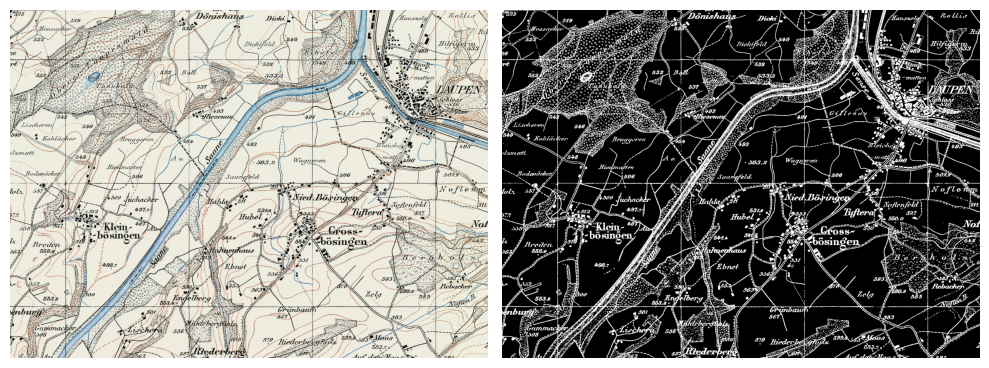

In [238]:
result_2 = segmentation_2(image_rgb)
plot_images(image_rgb, result_2)

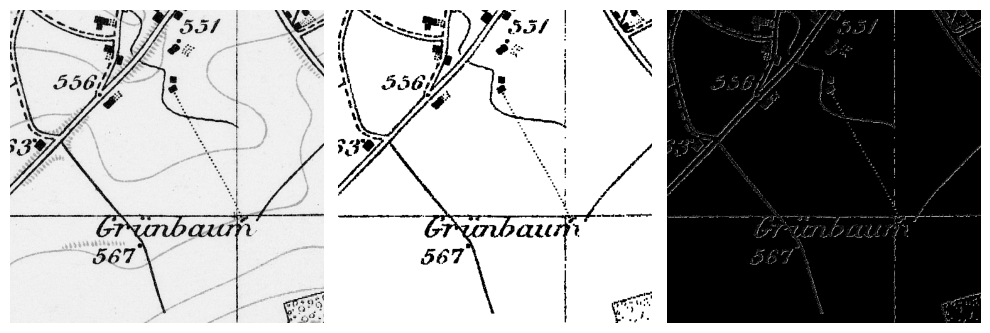

In [225]:
# Split the image into R, G, B channels
B2, G2, R2 = cv2.split(cropped_image_2)

# Define threshold values for each channel
threshold_R_2 = 50  # Adjust for Red channel
threshold_G_2 = 100  # Adjust for Green channel
threshold_B_2 = 25  # Adjust for Blue channel
threshold_Gray_2 = 50 # Adjust for Gray channel

# Step 1: Threshold each channel separately
_, thresh_R = cv2.threshold(R2, threshold_R_2, 255, cv2.THRESH_BINARY)
_, thresh_G = cv2.threshold(G2, threshold_G_2, 255, cv2.THRESH_BINARY)
_, thresh_B = cv2.threshold(B2, threshold_B_2, 255, cv2.THRESH_BINARY)
_, thresh_Gray = cv2.threshold(cropped_image_gray_2, threshold_Gray_2, 255, cv2.THRESH_BINARY)

B2_thresh_erosion = cv2.erode(thresh_B, kernel_2, iterations=1)

diff = cv2.subtract(B2, B2_thresh_erosion)
plot_images(B2, B2_thresh_erosion, diff)



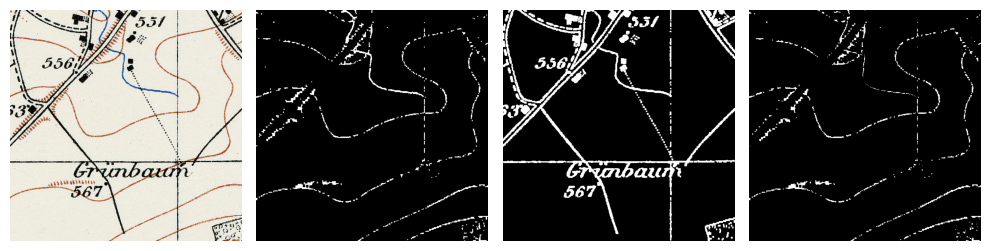

In [226]:
result_crop = segmentation(cropped_image_2)
result_2_crop = segmentation_2(cropped_image_2)
result_crop_diff = cv2.subtract(result_crop, result_2_crop)

plot_images(cropped_image_2, result_crop, result_2_crop, result_crop_diff)